In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from google.colab import files
import matplotlib.pyplot as plt

In [4]:
# Upload the file
uploaded = files.upload()

Saving Book1.csv to Book1.csv


In [5]:
df = pd.read_excel("Book1.csv")   # even if the extension is .csv
print(df.head())

            Timestamp  What is your age? What is Your Gender?  \
0 2025-07-21 13:38:43                 71                 Male   
1 2025-07-21 14:37:43                 55               Female   
2 2025-07-21 16:30:43                 27               Female   
3 2025-07-21 17:12:43                 42               Female   
4 2025-07-21 17:39:43                 76                 Male   

   What is your Height?  What is your Weight?  \
0                   163                    51   
1                   150                    93   
2                   145                    65   
3                   144                   137   
4                   171                   129   

  Have you engaged in any physical activity or exercise, other than your regular job, on at least 3 days per week  \
0                                                 No                                                                
1                                                Yes                            

In [6]:
# Rename columns if needed (optional) or just check the columns
print(df.columns)

Index(['Timestamp', 'What is your age?', 'What is Your Gender?',
       'What is your Height?', 'What is your Weight?',
       'Have you engaged in any physical activity or exercise, other than your regular job, on at least 3 days per week',
       'Do you smoke more than 10 cigarettes per day?',
       'Do you consume alcohol above this heavy drinking threshold?',
       'Has your mother or father ever been diagnosed with diabetes?',
       'Have you been diagnosed with diabetes at any point in your life?'],
      dtype='object')


In [7]:
# Drop unwanted columns (like Timestamp)
df = df.drop(columns=['Timestamp'])

In [8]:
# Target label: convert 'Have you been diagnosed with diabetes at any point in your life?' Yes/No to 1/0
df['Diabetes'] = df['Have you been diagnosed with diabetes at any point in your life?'].map({'Yes':1, 'No':0})

In [9]:
# Drop original label column
df = df.drop(columns=['Have you been diagnosed with diabetes at any point in your life?'])

In [10]:
# Encoding categorical features
# One-hot encode 'What is Your Gender?'
df = pd.get_dummies(df, columns=['What is Your Gender?'], prefix='Gender')

In [11]:
# Convert other Yes/No columns to 1/0
binary_cols = [
    'Have you engaged in any physical activity or exercise, other than your regular job, on at least 3 days per week',
    'Do you smoke more than 10 cigarettes per day?',
    'Do you consume alcohol above this heavy drinking threshold?',
    'Has your mother or father ever been diagnosed with diabetes?'
]
for col in binary_cols:
    df[col] = df[col].map({'Yes':1, 'No':0})

In [12]:
# Normalize numerical features: Age, Height, Weight (or BMI if present)
scaler = MinMaxScaler()
num_cols = ['What is your age?', 'What is your Height?', 'What is your Weight?']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [13]:
# Prepare features and target
X = df.drop(columns=['Diabetes'])
y = df['Diabetes']

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData split into training and testing sets:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Data split into training and testing sets:
X_train shape: (203, 10)
X_test shape: (51, 10)
y_train shape: (203,)
y_test shape: (51,)


In [15]:
# Calculate class weights for imbalance handling
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
print(f"\nCalculated Class Weights to handle imbalance: {class_weights_dict}")


Calculated Class Weights to handle imbalance: {0: np.float64(0.5901162790697675), 1: np.float64(3.274193548387097)}


In [16]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [17]:
# Define L2 regularization
l2_reg = regularizers.L2(0.001)

In [18]:
# Build model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),

    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2_reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 192 (768.00 B)

In [20]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

print("\nStarting model training with improvements...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Starting model training with improvements...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.4763 - loss: 0.9178 - val_accuracy: 0.2941 - val_loss: 0.7816 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5156 - loss: 0.7860 - val_accuracy: 0.5098 - val_loss: 0.7600 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4922 - loss: 0.8558 - val_accuracy: 0.6078 - val_loss: 0.7417 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4822 - loss: 0.8949 - val_accuracy: 0.6471 - val_loss: 0.7302 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5432 - loss: 0.8211 - val_accuracy: 0.7255 - val_loss: 0.7193 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5737 - loss: 0.6643 - val_accuracy: 0.8431 - val_loss: 0.7026 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - ac

In [21]:
# Evaluate model on test set
print("\nEvaluating final model performance on the test set...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Evaluating final model performance on the test set...

Test Accuracy: 88.24%
Test Loss: 0.4409


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


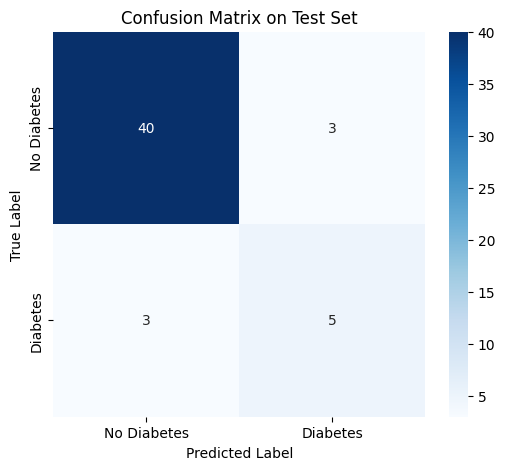

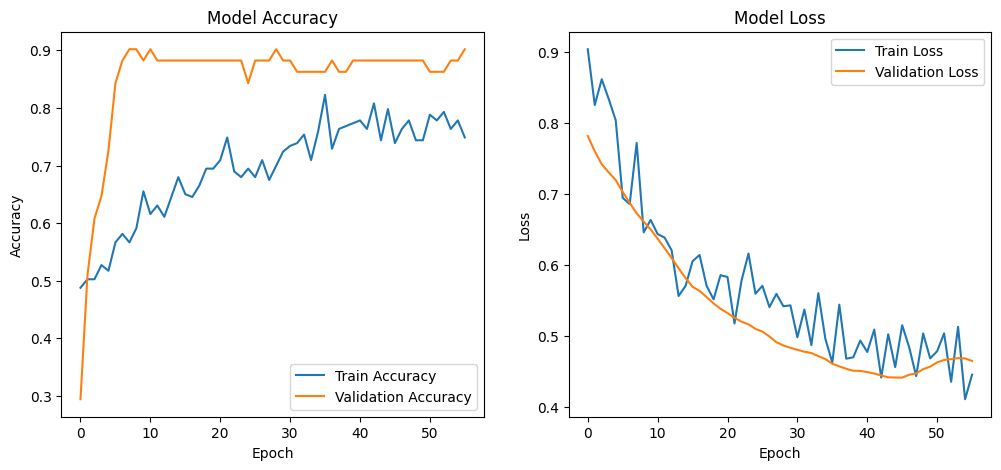

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary class predictions with threshold 0.5
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Plot training history
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary class predictions with threshold 0.5
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()
